# PyRSD: Reading
Here I explore the `pyRSD` package. My main purpose is to compute the covariance matrix of the multipole expansion of $P(k,\mu)$.

To install the `pyRSD` on NERSC, follow this instructions:
- https://github.com/nickhand/pyRSD_nersc/blob/master/docs/setup.md

<b> Caveat: </b>
1. The installation package is outdated.
2. I could install up to the point before load the C++/MPI libraries

The hask is to run this commands when the installation fails:

        module swap PrgEnv-intel PrgEnv-gnu
        module load gsl/2.7
        module unload fftw || true
        module load cray-fftw/3.3.8.10
        
        # load swig
        module load swig

        # tar pyRSD
        pip install -vvv -I --no-deps --global-option=build_ext --global-option="-I$FFTW_INC" pyRSD


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')

In [3]:
kwargs = {'r':r'$s \; [Mpc]$',
          'sxi': r'$ s^2 \xi(s)$',
          'xi': r'$  \xi$',
          'k': r"$k$ [$ \mathrm{Mpc}^{-1}$]",
          'pk': r"$k \times P(k, \mu)$ [$ \mathrm{Mpc}^2$]",
          'rperp': r'$r_{\perp} \; [Mpc]$',
          'pi': r'$r_{\parallel} \; [Mpc]$'
         }

## Starting the Tutorials

Following the cosmology overview page:
https://pyrsd.readthedocs.io/en/latest/cosmo-overview.html

The buzzard Cosmology:
```
Ωm = 0.286, h = 0.7, σ8 = 0.82, ns = 0.96, and Ωb = 0.046, with three massless neutrino species and Ne f f = 3.046.

```

In [4]:
from pyRSD.rsd import cosmology
h=0.7
cosmo = cosmology.Cosmology(H0=70, sigma8=0.82, n_s=0.96)

In [5]:
# from pyRSD.rsd.hzpt import HaloZeldovichP00, HaloZeldovichP01, HaloZeldovichP11, HaloZeldovichPhm
from pyRSD.rsd import hzpt

# power spectrum at z = 0
P00 = hzpt.HaloZeldovichP00(cosmo, z=0.55)
# P01 = hzpt.HaloZeldovichP01(cosmo, z=0.55)
# P11 = hzpt.HaloZeldovichP11(cosmo, z=0.55)
Phm = hzpt.HaloZeldovichPhm(cosmo, z=0.55)


In [6]:
# compute the full power and each term
k = np.logspace(-2, 0, 100)*h
Pk = P00(k)/h**3
Pzel = P00.zeldovich(k)
Pbb = P00.broadband(k)


Text(0, 0.5, '$k \\times P(k, \\mu)$ [$ \\mathrm{Mpc}^2$]')

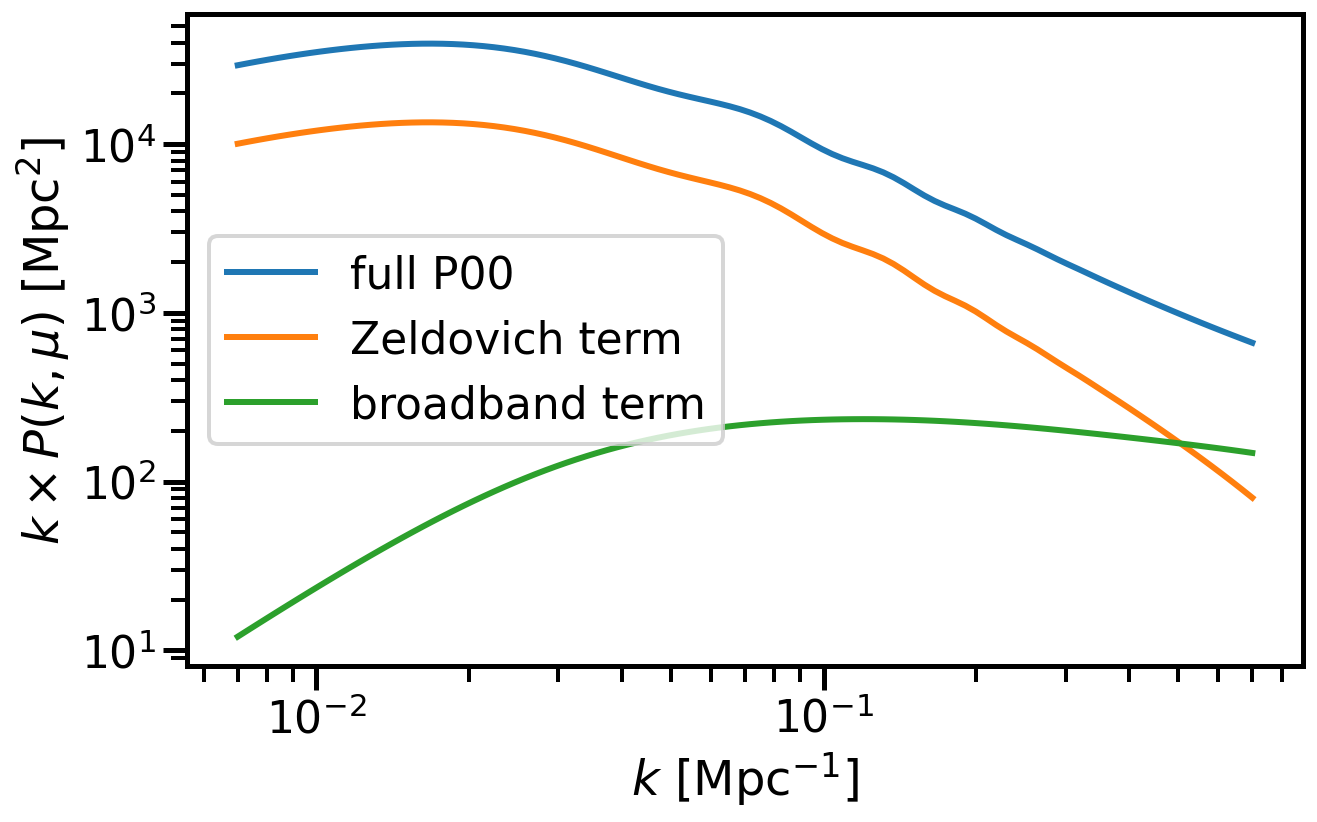

In [7]:
# and plot
plt.figure(figsize=(10,6))
plt.loglog(k, Pk, label='full P00')
plt.loglog(k, Pzel, label='Zeldovich term')
plt.loglog(k, Pbb, label='broadband term')
plt.legend()
plt.xlabel(kwargs['k'])
plt.ylabel(kwargs['pk'])

## Load my data

In [8]:
from bokeh.palettes import Magma, Inferno, Plasma, Viridis, Cividis

colors = Plasma[7]

In [9]:
# box 0 and 1

powers = []
for i in range(2):
    fname = '../data/power_vec_box%i.npy'%i
    powers.append(np.load(fname))

In [10]:
# shape (nk, nmu)
# Pkmu
powers[0]['power'].real.shape

(133, 5)

In [11]:
kvec = powers[0]['k'][:,0]

In [12]:

def plot_profiles(box_id=0):
    pkmus = powers[box_id]['power'].real
    kmus = powers[box_id]['k']
    mubins = powers[box_id]['mu'][0]
    
    for i in range(kmus.shape[1]):
        plt.scatter(kmus[:,i], kmus[:,i]*pkmus[:,i], alpha=0.5, s=50, color=colors[i])

    plt.legend(labels=['$\mu =%.2f$'%mu for mu in mubins])


    plt.xlabel(kwargs['k'])
    plt.ylabel(kwargs['pk'])
    # plt.ylim(1e3, 5.5e4)
    # plt.xlim(0.01, 0.25)
    plt.xlim(0.01,1.1)
    plt.title('Buzzard Mock - Box %i'%box_id)


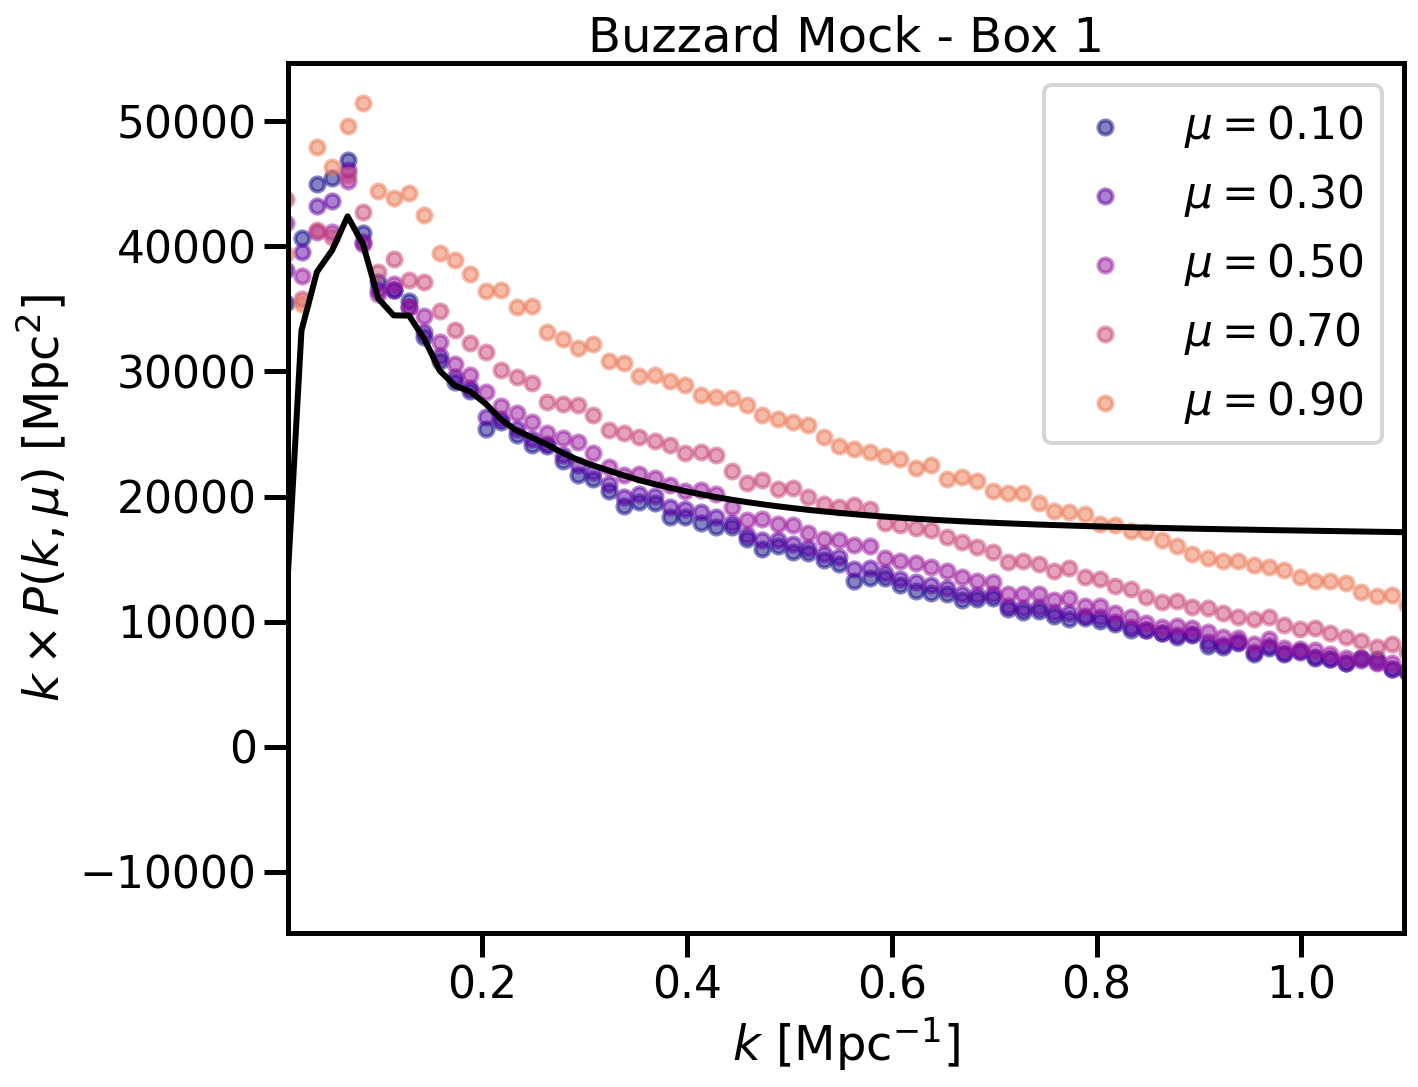

In [13]:
bias = 6.2
plt.figure(figsize=(10,8))
plot_profiles(1)
plt.plot(kvec, kvec*P00(kvec)*bias**2/h**3, label='full P00', color='k')
# plt.plot(kvec, kvec*Phm(2,kvec)*bias**2/h**3, label='full P00', color='k')


In [16]:
from pyRSD.rsdfit.data import PowerMeasurements
names = ['pkmu_0.1', 'pkmu_0.3', 'pkmu_0.5', 'pkmu_0.7', 'pkmu_0.9']
measurements = PowerMeasurements.from_array(names, powers[0])
measurements

[<PowerMeasurement P(k, mu=0.1), (0.00987 - 1.99) h/Mpc, 133 data points>,
 <PowerMeasurement P(k, mu=0.3), (0.00987 - 1.99) h/Mpc, 133 data points>,
 <PowerMeasurement P(k, mu=0.5), (0.00987 - 1.99) h/Mpc, 133 data points>,
 <PowerMeasurement P(k, mu=0.7), (0.00987 - 1.99) h/Mpc, 133 data points>,
 <PowerMeasurement P(k, mu=0.9), (0.00987 - 1.99) h/Mpc, 133 data points>]

In [27]:
from pyRSD.rsdfit.data import PoleCovarianceMatrix, PkmuCovarianceMatrix


# make the full data vector
# D = np.concatenate([P0, P2, P4], axis=-1) # shape is (100, 60)
D = powers[0]['power'].real

# compute the covariance matrix
cov = np.cov(D, rowvar=False) # shape is (20,20)

# initialize the PoleCovarianceMatrix
ells = [0,2,4]

# k_edges = np.linspace(0.01, 0.4, Nk+1)
# k_cen = 0.5 * (k_edges[1:] + k_edges[:-1])
k_cen = powers[0]['k'][:,0]

In [42]:
def periodic_gaussian_covariance(model, k, mu_edges, nbar, volume, Nmu=100):
    r"""
    Return the Gaussian prediction for the covariance between
    :math:`P(k,\mu)` wedges for a periodic box simulation, where the number
    density is constant.
    See eq. 17 of Grieb et al. 2015 arxiv:1509.04293
    Parameters
    ----------
    model : GalaxySpectrum, QuasarSpectrum
        the model instance used to evaluate the theoretical :math:`P(k,\mu)`
    k : array_like
        the array of wavenumbers (units of :math:`h/\mathrm{Mpc}`) where
        the covariance matrix will be evaluated
    mu_edges : array_like
        the edges of the :math:`\mu` bins
    nbar : float
        the constant number density in the box in units of
        :math:`(\mathrm{Mpc}/h)^{-3}` -- the shot noise contribution
        to the covariance is the inverse of this value
    volume : float
        the volume of the box, in units of :math:`(\mathrm{Mpc}/h)^3`
    Nmu : int, optional
        the number of mu bins to use when performing the multipole integration
        over :math:`\mu`
    Returns
    -------
    PkmuCovarianceMatrix :
        the covariance matrix object holding the Gaussian prediction for
        the covariance between the specified wedges
    Examples
    --------
    >>> import numpy
    >>> from pyRSD.rsd import GalaxySpectrum
    >>> from pyRSD.rsdfit.data import PkmuCovarianceMatrix
    >>> volume = 1380.0**3
    >>> nbar = 3e-4
    >>> model = GalaxySpectrum(params='boss_dr12_fidcosmo.ini')
    >>> k = numpy.arange(0., 0.4, 0.005) + 0.005/2
    >>> mu_edges = [0., 0.2, 0.4, 0.6, 0.8, 1.0]
    >>> C = PkmuCovarianceMatrix.periodic_gaussian_covariance(model, k, ells, nbar, volume)
    """
    Nwedge = len(mu_edges) - 1
    ndims = (len(k)+2, Nwedge+2)
    mu_edges = np.asarray(mu_edges)

    # the best-fit P(k,mu)
    fine_mu_edges = np.linspace(0, 1, Nmu+1)
    mu_cen = 0.5*(fine_mu_edges[1:] + fine_mu_edges[:-1])
    
    # Replace here
    Pkmu = model(k, mu_cen)
    
    
    _, mus = np.meshgrid(k, mu_cen, indexing='ij')

    # determine the mu indices for binning
    k_idx = np.arange(len(k), dtype=int)[:,None]
    dig_k = np.repeat(k_idx, Nmu, axis=1) + 1
    dig_mu = np.digitize(mus, mu_edges)
    mu_indices = np.ravel_multi_index([dig_k, dig_mu], ndims)

    # determine the number of modes
    dk = np.diff(k).mean()
    Vk  = 4*np.pi*k**2*dk
    N = Vk * volume / (2*np.pi)**3
    N = np.repeat(N[:,None], Nmu, axis=1) * np.diff(fine_mu_edges)

    Psq = (Pkmu + 1./nbar)**2

    def bin(d, average=False):
        toret = np.zeros(ndims)
        minlength = np.prod(ndims)
        toret.flat = np.bincount(mu_indices.flat, weights=d.flat, minlength=minlength)
        norm = 1.0
        if average:
            norm = np.zeros(ndims)
            norm.flat = np.bincount(mu_indices.flat, minlength=minlength)
            norm = np.squeeze(norm.reshape(ndims)[1:-1, 1:-1])
        toret = np.squeeze(toret.reshape(ndims)[1:-1, 1:-1])
        return toret/norm

    Psq = bin(Psq, average=True)
    modes = bin(N, average=False)

    N1 = len(k); N2 = Nwedge
    C = numpy.zeros((N1,N2)*2)
    for i in range(Nwedge):
        C[:,i,:,i] = np.diag(np.nan_to_num(2*Psq[:,i]/modes[:,i]))

    C = C.reshape((N1*N2,)*2, order='F')

    # the coordinate arrays
    k_coord = np.concatenate([k for i in range(Nwedge)])
    mu_cen = (mu_edges[1:] + mu_edges[:-1])*0.5
    mu_coord = np.concatenate([np.ones(len(k), dtype=int)*mu for mu in mu_cen])

    return C, k_coord, mu_coord

In [31]:
from pyRSD.rsd import GalaxySpectrum
model = GalaxySpectrum(z=0, params=cosmo)


In [40]:
model.initialize()
# set kmin/kmax limits
model.kmin = 1e-3
model.kmax = 0.5

AttributeError: 'DataFrame' object has no attribute '_attrs'

In [41]:
# help(model.power_lin_nw)

In [39]:
model.power(kvec, ells)

AttributeError: 'DataFrame' object has no attribute '_attrs'

In [30]:
import numpy
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from pyRSD.rsd import GalaxySpectrum
from pyRSD.rsdfit.data import PoleCovarianceMatrix

# load n(z) from file and interpolate it
filename = 'nbar_DR12v5_CMASSLOWZ_North_om0p31_Pfkp10000.dat'
nbar = numpy.loadtxt(filename, skiprows=3)
nbar = spline(nbar[:,0], nbar[:,3])

# the sky fraction the survey covers
fsky = 0.1436

# the model instance to compute P(k,mu)
model = GalaxySpectrum(params='boss_dr12_fidcosmo.ini')

# the k values to compute covariance at
k = numpy.arange(0., 0.4, 0.005) + 0.005/2

# the multipoles to compute covariance of
ells = [0,2,4]

# the redshift range of the survey
zmin = 0.2
zmax = 0.5

# the FKP weight P0
P0_FKP = 1e4

# the PoleCovarianceMatrix holding the Gaussian covariance
C = PoleCovarianceMatrix.cutsky_gaussian_covariance(model, k, ells, nbar, fsky, zmin, zmax, P0_FKP=P0_FKP)

OSError: nbar_DR12v5_CMASSLOWZ_North_om0p31_Pfkp10000.dat not found.

In [ ]:
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from pyRSD.rsdfit.data import PoleCovarianceMatrix

# load n(z) from file and interpolate it
filename = 'nbar_DR12v5_CMASSLOWZ_North_om0p31_Pfkp10000.dat'
nbar = numpy.loadtxt(filename, skiprows=3)
nbar = spline(nbar[:,0], nbar[:,3])

# the sky fraction the survey covers
fsky = 1/8.

# the model instance to compute P(k,mu)
model = GalaxySpectrum(params='boss_dr12_fidcosmo.ini')

# the k values to compute covariance at
k = numpy.arange(0., 0.4, 0.005) + 0.005/2

# the multipoles to compute covariance of
ells = [0,2,4]

# the redshift range of the survey
zmin = 0.2
zmax = 0.5

# the FKP weight P0
P0_FKP = 1e4

# the PoleCovarianceMatrix holding the Gaussian covariance
C = PoleCovarianceMatrix.cutsky_gaussian_covariance(model, k, ells, nbar, fsky, zmin, zmax, P0_FKP=P0_FKP)